In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

In [2]:
# Define transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.0,), (0.1,))])

# Download and load MNIST dataset using torchvision
train_dataset = torchvision.datasets.MNIST(
    root='../datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(
    root='../datasets', train=False, download=True, transform=transform)

In [3]:
# Flatten the images for sklearn MLP
X_train = train_dataset.data.float().reshape(len(train_dataset), -1)
y_train = train_dataset.targets
X_test = test_dataset.data.float().reshape(len(test_dataset), -1)
y_test = test_dataset.targets

In [4]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = torch.from_numpy(scaler.fit_transform(X_train))
X_test_scaled = torch.from_numpy(scaler.transform(X_test))

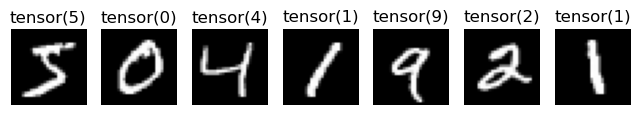

In [5]:
# Plot few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i].reshape((28, 28)), cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

In [21]:
# MLP model
class MLP(nn.Module):
    def __init__(self, dim1, dim2, l1, l2, out_layer):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(dim1*dim2, l1)
        self.activation1 = nn.ReLU()
        self.lin2 = nn.Linear(l1, l2)
        self.activation2 = nn.ReLU()
        self.lin3 = nn.Linear(l2, out_layer)

    def forward(self, x):
        a0 = x.view(x.shape[0], -1)
        z1 = self.lin1(a0)
        a1 = self.activation1(z1)
        z2 = self.lin2(a1)
        a2 = self.activation2(z2)
        z3 = self.lin3(a2)
        out = F.log_softmax(z3, dim=1)
        return out, a2

In [22]:
model = MLP(28, 28, 30, 20, 10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=784, out_features=30, bias=True)
  (activation1): ReLU()
  (lin2): Linear(in_features=30, out_features=20, bias=True)
  (activation2): ReLU()
  (lin3): Linear(in_features=20, out_features=10, bias=True)
)

In [23]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([30, 784])
lin1.bias torch.Size([30])
lin2.weight torch.Size([20, 30])
lin2.bias torch.Size([20])
lin3.weight torch.Size([10, 20])
lin3.bias torch.Size([10])


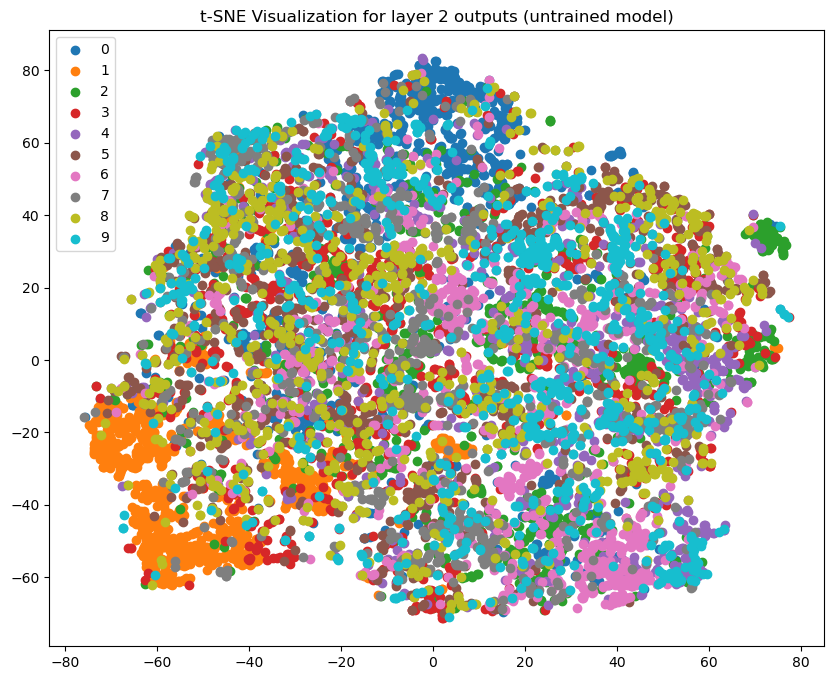

In [24]:
# t-SNE on output of layer 2 of untrained model:
with torch.no_grad():
    y_layer2_untrained = model(X_test.to(device))[1].cpu().numpy()
    # print device of y_layer2_untrained

tsne_untrained = TSNE(n_components=2)
tsne_outputs_untrained = tsne_untrained.fit_transform(y_layer2_untrained)
# print(tsne_outputs_untrained.device)
# Plot t-SNE for the trained model
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_outputs_untrained[y_test == i][:, 0],
                tsne_outputs_untrained[y_test == i][:, 1], label=str(i))
plt.title('t-SNE Visualization for layer 2 outputs (untrained model)')
plt.legend()
plt.show()

In [25]:
# Training the model
import time
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
# Mini-batch training
batch_size = 5000
print_every = 100
# elapsed_time = []
for epoch in range(1000):
    # start_time = time.time()
    for i in range(0, X_train.shape[0], batch_size):
        x = X_train[i:i+batch_size].to(device)
        y = y_train[i:i+batch_size].to(device)
        y_pred = model(x)[0]
        loss = loss_fn(y_pred, y)
        loss.backward() 
        opt.step()
        opt.zero_grad()
    # end_time = time.time()
    # elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 2.042691469192505
100 0.22033371031284332
200 0.19873403012752533
300 0.18928246200084686
400 0.15518763661384583
500 0.16317561268806458
600 0.145067036151886
700 0.14570729434490204
800 0.1442464292049408
900 0.1404085010290146


F1 Score(MLP): 0.9198728407445331
Confusion Matrix:


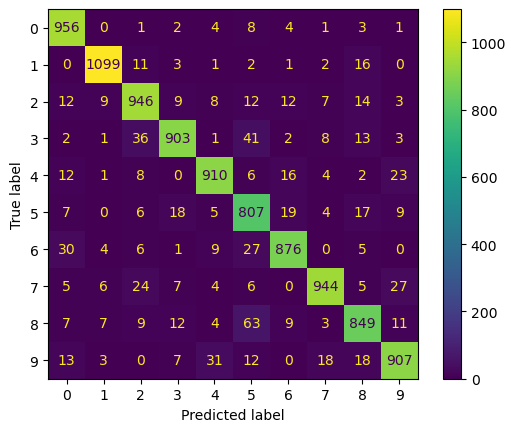

In [26]:
with torch.no_grad():
    y_odds_mlp = model(X_test)[0]
    y_pred_mlp = torch.max(y_odds_mlp.data, 1)[1]
    f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
    cf_mlp = confusion_matrix(y_test, y_pred_mlp)
    print(f"F1 Score(MLP): {f1_mlp}")
    print("Confusion Matrix:")
    cm_display = ConfusionMatrixDisplay(cf_mlp).plot(
        values_format='d', cmap='viridis', ax=plt.gca())
    

F1 Score (RF): 0.9704722695987773
Confusion Matrix:


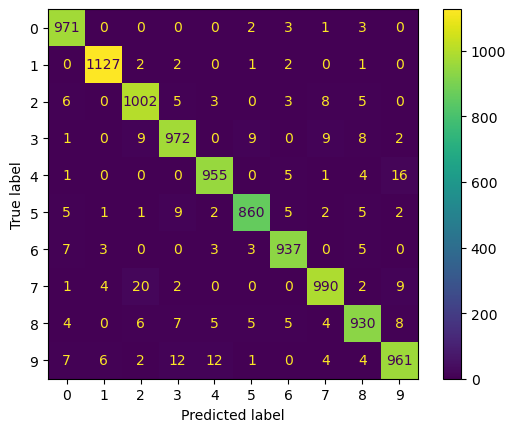

In [15]:
# Random Forrest
# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)

# Calculate F1-score and confusion matrix
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"F1 Score (RF): {f1_rf}")
print("Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(cm_rf).plot(
    values_format='d', cmap='viridis', ax=plt.gca())

F1 Score (LR): 0.9210516141720867
Confusion Matrix:


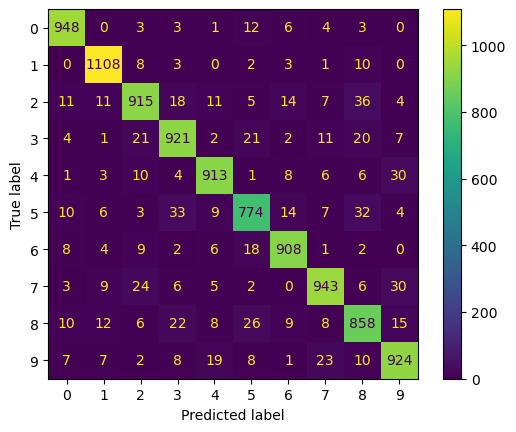

In [16]:
# Logistic Regression
# Initialize the Logistic Regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lr = lr_clf.predict(X_test_scaled)

# Calculate F1-score and confusion matrix
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"F1 Score (LR): {f1_lr}")
print("Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(cm_lr).plot(
    values_format='d', cmap='viridis', ax=plt.gca())

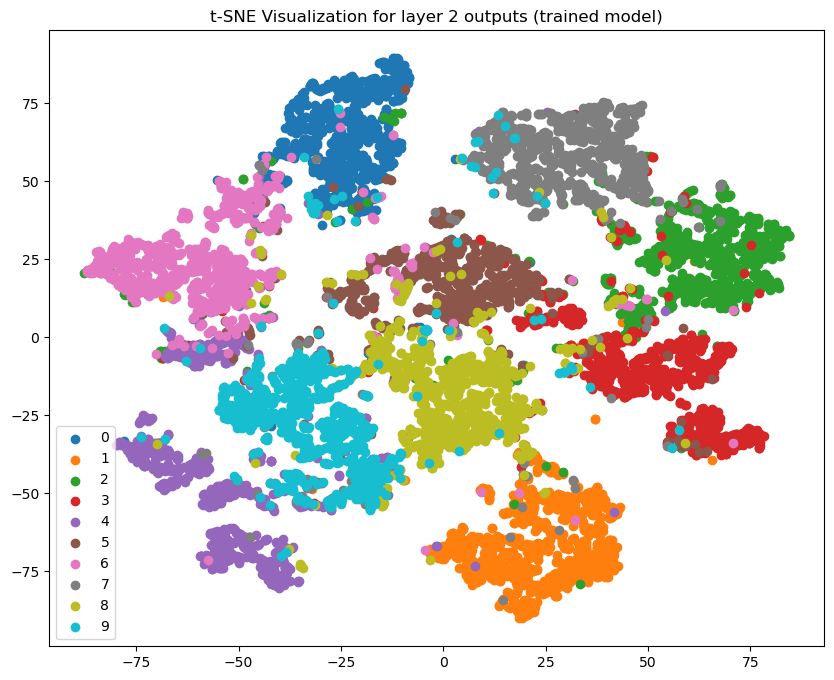

In [27]:
# t-SNE on output of layer 2 of untrained model:
with torch.no_grad():
    y_layer2_trained = model(X_test.to(device))[1].cpu().numpy()
    # print device of y_layer2_untrained

tsne_trained = TSNE(n_components=2)
tsne_outputs_trained = tsne_trained.fit_transform(y_layer2_trained)
# print(tsne_outputs_untrained.device)
# Plot t-SNE for the trained model
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_outputs_trained[y_test == i][:, 0],
                tsne_outputs_trained[y_test == i][:, 1], label=str(i))
plt.title('t-SNE Visualization for layer 2 outputs (trained model)')
plt.legend()
plt.show()

In [29]:
#for Fashion MNIST
# Download and load FashionMNIST dataset using torchvision
train_fashion_dataset_2 = torchvision.datasets.FashionMNIST(
    root='../datasets', train=True, download=True, transform=transform)
test_fashion_dataset_2 = torchvision.datasets.FashionMNIST(
    root='../datasets', train=False, download=True, transform=transform)

In [31]:
# Flatten the images for sklearn MLP
X_train_2 = train_fashion_dataset_2.data.float().reshape(len(train_dataset), -1)
y_train_2 = train_fashion_dataset_2.targets
X_test_2 = test_fashion_dataset_2.data.float().reshape(len(test_dataset), -1)
y_test_2 = test_fashion_dataset_2.targets

In [32]:
X_train_2.shape,y_train_2.shape,X_test_2.shape,y_test_2.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [33]:
X_train_scaled_2 = torch.from_numpy(scaler.fit_transform(X_train_2))
X_test_scaled_2 = torch.from_numpy(scaler.transform(X_test_2))

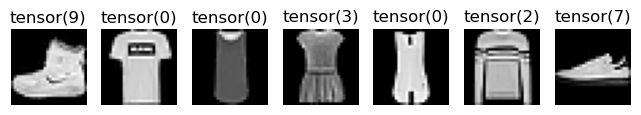

In [34]:
# Plot few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train_2[i].reshape((28, 28)), cmap='gray')
    axs[i].set_title(y_train_2[i])
    axs[i].axis('off')

F1 Score (fashion MNIST): 0.04192083353535164
Confusion Matrix:


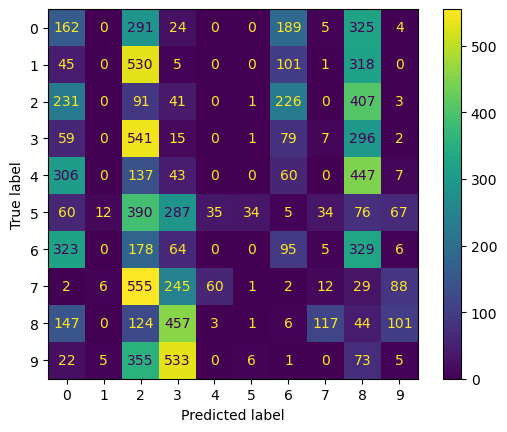

In [35]:
with torch.no_grad():
    y_odds_mlp_2 = model(X_test_2)[0]
    y_pred_mlp_2 = torch.max(y_odds_mlp_2.data, 1)[1]
    f1_mlp_2 = f1_score(y_test_2, y_pred_mlp_2, average='weighted')
    cf_mlp_2 = confusion_matrix(y_test_2, y_pred_mlp_2)
    print(f"F1 Score (fashion MNIST): {f1_mlp_2}")
    print("Confusion Matrix:")
    cm_display = ConfusionMatrixDisplay(cf_mlp_2).plot(
        values_format='d', cmap='viridis', ax=plt.gca())

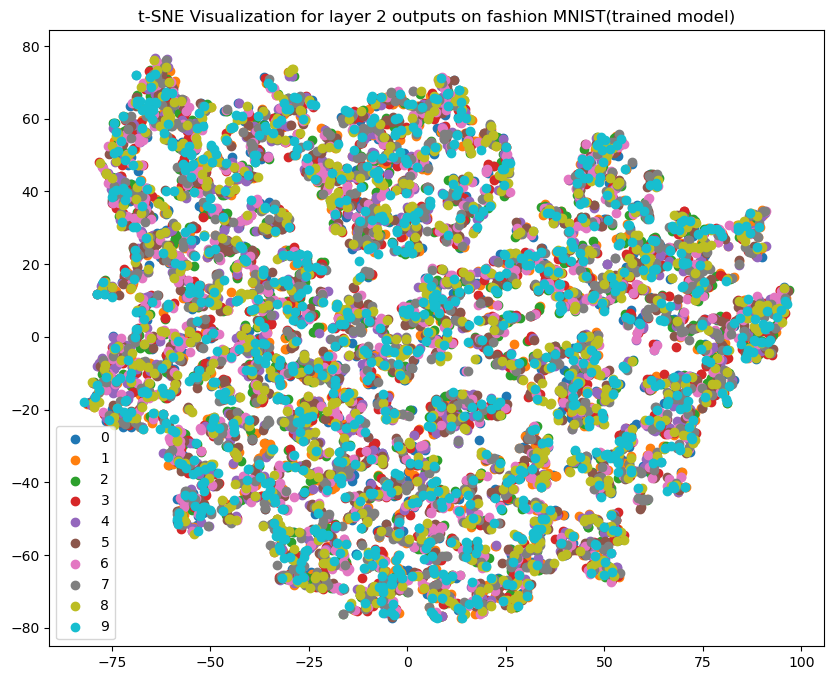

In [36]:
# t-SNE on output of layer 2 of untrained model:
with torch.no_grad():
    y_layer2_trained_2 = model(X_test_2.to(device))[1].cpu().numpy()
    # print device of y_layer2_untrained

tsne_trained_2 = TSNE(n_components=2)
tsne_outputs_trained_2 = tsne_trained_2.fit_transform(y_layer2_trained_2)
# print(tsne_outputs_untrained.device)
# Plot t-SNE for the trained model
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_outputs_trained_2[y_test == i][:, 0],
                tsne_outputs_trained_2[y_test == i][:, 1], label=str(i))
plt.title('t-SNE Visualization for layer 2 outputs on fashion MNIST(trained model)')
plt.legend()
plt.show()